# Action PixelBytes: Catching Insights in Unified Multimodal Sequences

## Description

Changement de la representation du modele, test d'un token "image, son, texte", mais avec l'ajout d'un vecteur positionnel uniquement pour l'image, le son et le texte. L'idée est de faire une quantification vectorielles des elements et ne donner que la valeurs des centroid "token" et leurs positions 3D. Contrairement au methodes haut niveau (encoder, VAE, etc.) pour construire le vecteur, ici, nous nous restreindrons à des valeurs predifini (palette, bytes) et un simple algorithme K-mean implementé en PyTorch pour la compression. La reconstruction se fera simplement par un Voronoï.


In [2]:
!pip install -q datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [8]:
from datasets import load_dataset
hf_dataset = load_dataset("ffurfaro/PixelBytes-PokemonAll")#['train'].train_test_split(test_size=0.1, seed=42)

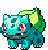

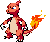

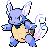

In [9]:
for i in range(0,9,3) :
    display(hf_dataset['train']['image'][i])

In [30]:
import torch
import numpy as np
from PIL import Image, ImageSequence

gif_image = hf_dataset['train']['image'][0]
frames = torch.stack([torch.tensor(np.array(frame.copy().convert('RGB'))).permute(2, 0, 1) for frame in ImageSequence.Iterator(gif_image)])
print(np.array(gif_image).shape, frames.shape)

(50, 48, 3) torch.Size([49, 3, 50, 48])


In [31]:
N, C, H, W = frames.shape
X = frames.view(N, C, -1).permute(0, 2, 1).reshape(-1, C).float()

# Implémentation du K-means
def kmeans(X, n_clusters, max_iters=100):
    # Initialisation aléatoire des centroids
    centroids = X[torch.randperm(X.shape[0])[:n_clusters]]

    for _ in range(max_iters):
        # Calcul des distances
        distances = torch.cdist(X, centroids)

        # Attribution des clusters
        labels = torch.argmin(distances, dim=1)

        # Mise à jour des centroids
        new_centroids = torch.stack([X[labels == k].mean(dim=0) for k in range(n_clusters)])

        # Vérification de la convergence
        if torch.all(centroids == new_centroids):
            break

        centroids = new_centroids

    return labels, centroids

# Application du clustering
n_clusters = 5  # Nombre de clusters souhaité
labels, centroids = kmeans(X, n_clusters)

# Reconstruction de l'image clusterisée
clustered_frames = centroids[labels].view(N, H, W, C).permute(0, 3, 1, 2)

TypeError: Invalid shape (3, 50, 48) for image data

Error in callback <function _draw_all_if_interactive at 0x7d2595e4e4d0> (for post_execute):


TypeError: Invalid shape (3, 50, 48) for image data

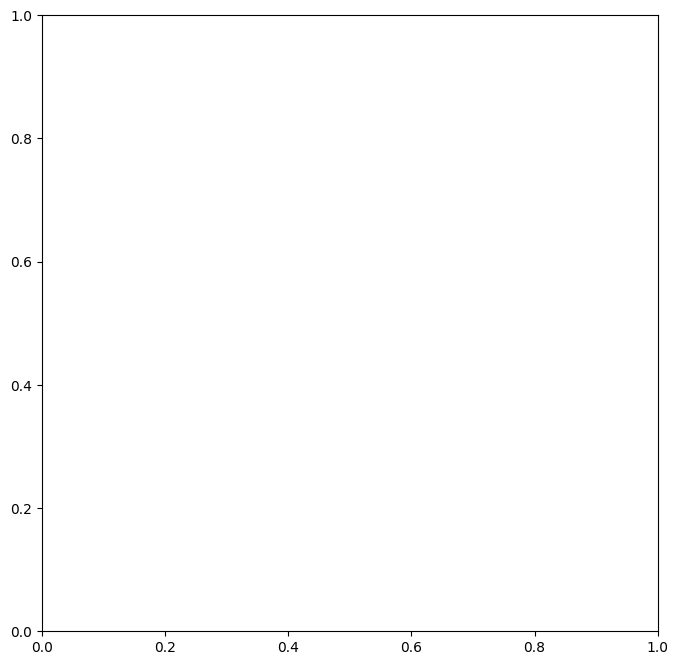

In [35]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Réorganisation des dimensions
clustered_frames = clustered_frames.permute(0, 2, 3, 1)

# Fonction pour initialiser l'animation
def init():
    return plt.imshow(clustered_frames[0].cpu().numpy())

# Fonction pour mettre à jour chaque frame
def update(frame):
    plt.clf()
    return plt.imshow(clustered_frames[frame].cpu().numpy())

# Création de l'animation
fig = plt.figure(figsize=(8, 8))
anim = FuncAnimation(fig, update, frames=range(N), init_func=init, interval=100)

# Affichage de l'animation
HTML(anim.to_jshtml())